In [1]:
from utils import *
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
a = np.load("spectr/"+os.listdir("spectr/")[55])

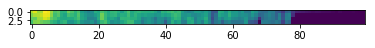

In [21]:
plt.imshow(a[:,100:200])

In [2]:
def get_data(npy_path):
    data_matr = np.load(npy_path)
    return np.array([np.array([y[0] for y in x]) for x in data_matr]),\
        np.array([np.array([y[1] for y in x]) for x in data_matr])

    
def get_spectrogram(y, sr=43680):
    S = melspectrogram(y, sr=sr, n_mels=200)
    log_S = logamplitude(S, ref_power=np.max)
    return log_S



def get_spectrs(music, block_size=20, dump_path="spectr/"):
    p = Pool(32)

    for ind, mus in enumerate(music):
        def _spec(i):
            spec = get_spectrogram(mus[i:i+block_size].reshape(-1), 43680).T 
            spec.dump("{}{}.{}.spec".format(dump_path, ind, i))
        p.map(_spec, range(0, len(music)-block_size, 1))
#         for i in range(0, len(music)-block_size, 1):
#             spec = get_spectrogram(mus[i:i+block_size].reshape(-1), 43680).T 
#             spec.dump("{}{}.{}.spec".format(dump_path, ind, i))
            
            
def iterate_minibatches(points, music, batch_size=100, block_size=20):
    blocks_left = [int(p.shape[0]/block_size) for p in points]
    blocks_total = blocks_left
    moves = np.array([positions_to_moves(x) for x in points])
    batch_count = 0
    train_moves = []; pred_move = []; start_pos = []; out_spec = []  
    while np.any(blocks_left != 0):
        inst = np.random.choice(range(len(blocks_left)))
        start = -blocks_left[inst]*block_size
        fin = start+block_size            

        train_moves.append(moves[inst][start:fin-1])
        
        pred_move.append(moves[inst][fin])

        start_pos.append(points[inst][start])
        
        our_spec = np.load("spectr/{}.{}.spec".format(inst, blocks_total[inst]-blocks_left[inst]))
        out_spec.append(our_spec)

        blocks_left[inst] -= 1


        if len(train_moves) == batch_size:
            yield np.array(out_spec), np.array(train_moves), np.array(start_pos), np.array(pred_move)
            train_moves = []; pred_move = []; start_pos = []; out_spec = []  

In [ ]:
block_size = 20; dump_path = "spectr/"
p = Pool(32)

def _spec(i, block_size, dump_path, ind, mus):
        spec = get_spectrogram(mus[i:i+block_size].reshape(-1), 43680).T 
        spec.dump("{}{}.{}.spec".format(dump_path, ind, i))

for ind, mus in enumerate(music):
    p.map(_spec, range(0, len(mus)-block_size, 1),
          [block_size for _ in range(0, len(mus)-block_size, 1)],
          [dump_path for _ in range(0, len(mus)-block_size, 1)], [ind for _ in range(0, len(mus)-block_size, 1)],
         [mus for _ in range(0, len(mus)-block_size, 1)])

In [2]:
point, music = get_data("ok_dat.npy")

In [28]:
get_spectrs(music)

In [ ]:
print("Dct")

In [8]:
def iterate_minibatches(points, music, batch_size=100, block_size=20, pool_size=32):
    p = Pool(pool_size)
    
    blocks_left = [int(p.shape[0]/block_size) for p in points]
    blocks_total = blocks_left
    
    moves = np.array([positions_to_moves(x) for x in points])
    
    total_batch = np.sum(blocks_total)
    #pool_size = int(total_batch/pool_size)
    pool_indexes = [[] for _ in range(pool_size)]
    
    train_moves = []; pred_move = []; start_pos = []; out_spec = []
    #for batch in range(len(total_batch)):
    #    inst = np.random.choice(range(len(blocks_left)))
    #    pl = np.random.choice(range(len(pool_size)))
    #    pool_indexes[pl].append((inst, blocks_total[inst]-blocks_left[inst]))
    
    i = 0
    for rec in range(len(points)):
        pool_indexes[i] = (i, 0, batch_size*2)
        i += 1
    def get_vecs(pos):
        train_moves = []; pred_move = []; start_pos = []; out_spec = []
        for i in range(pos[1], pos[2], batch_size):
            
            train_moves.append(moves[pos[0]][i:i+batch_size])

            pred_move.append(moves[pos[0]][i+batch_size])

            start_pos.append(points[pos[0]][i])

            our_spec = np.load("spectr/{}.{}.spec".format(pos[0], int(i/batch_size)))
            out_spec.append(our_spec)
        return [out_spec, train_moves, start_pos, pred_move]
    
    a = np.array(p.map(get_vecs, pool_indexes))
    
    #for ind, rec in enumerate(points):
     #   batch_num = int(len(rec)/batch_size)
     #   curr_batch = 0
     #   pool_batch = int(batch_num/(pool_size-1))
     #   pool_left = batch_num%pool_size
     #   for count, i in enumerate(range(0, len(rec)-pool_batch*batch_size, pool_batch*batch_size)):
     #       print(count)
    #        pool_indexes[count].append((ind, i, i+pool_batch*batch_size))
    #print(np.array(pool_indexes).shape)
    #while np.any(blocks_left != 0):
    #    inst = np.random.choice(range(len(blocks_left)))
    #    start = -blocks_left[inst]*block_size
    #    fin = start+block_size
    #    pool_indexes.append((inst, start, fin))
    #    blocks_left[inst] -= 1
    #print(np.array(pool_indexes).shape)
    #    if fin < moves.shape[0]:
    #        train_moves.append(moves[inst][start:fin-1])
#
 #           pred_move.append(moves[inst][fin])
#
 #           start_pos.append(points[inst][start])

  #          our_spec = np.load("spectr/{}.{}.spec".format(inst, blocks_total[inst]-blocks_left[inst])
   #         out_spec.append(our_spec)
    print(a.shape)

        #blocks_left[inst] -= 1


        #if len(train_moves) == batch_size:
         #   yield np.array(out_spec), np.array(train_moves), np.array(start_pos), np.array(pred_move)
          #  train_moves = []; pred_move = []; start_pos = []; out_spec = []  

In [9]:
a = iterate_minibatches(point, music)

KeyboardInterrupt: 

In [ ]:
def iterate_minibatches(points, music, batch_size=100, block_size=20, pool_count=32):
    def get_vecs(pos):
        train_moves = []; pred_move = []; start_pos = []; out_spec = []
        for p in pos:
            inst = p[0]; min_ = p[1]; max_ = p[2]

            for i in range(min_, max_, batch_size):

                train_moves.append(moves[inst][i:i+batch_size])

                pred_move.append(moves[inst][i+batch_size])

                start_pos.append(points[inst][i])

                our_spec = np.load("spectr/{}.{}.spec".format(inst, int(i/batch_size)))
                out_spec.append(our_spec)
            return [out_spec, train_moves, start_pos, pred_move]
    
    pool = Pool(pool_count)
    pools = [[] for _ in range(pool_count)]
    moves = np.array([positions_to_moves(x) for x in points])
    for index, rec in enumerate(points):
        num_blocks = int(len(rec)/block_size)
        blocks_in_pool = int(num_blocks/pool_count)
        num_blocks = blocks_in_pool*pool_count
        for curr, i in enumerate(range(0, num_blocks*block_size-blocks_in_pool*block_size, block_in_pool*block_size)):
            pools[curr].append((index, i,i+block_in_pool*block_size)) 
    
    return pools

In [ ]:
a = iterate_minibatches([point[0]], [music[0]])

In [ ]:
a